# 📝 **Project section1**

# 목차
## 1. 샘플데이터 불러오기
## 2. 데이터 전처리
## 3. 필수포함 주제
## 4. 다음 분기에 어떤 게임을 설계해야 할까


# 1. 샘플 데이터 불러오기

In [ ]:

import pandas as pd 
df=pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/vgames2.csv')
print(df.columns)
df.head()


Index(['Unnamed: 0', 'Name', 'Platform', 'Year', 'Genre', 'Publisher',
       'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'],
      dtype='object')


,Unnamed: 0,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,1,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
1,2,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
2,3,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
3,4,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
4,5,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04


# 2. 데이터 전처리


In [ ]:


import numpy as np

# 첫번째 열 삭제
try:
  df=df.drop(['Unnamed: 0'], axis=1)
except:
  pass

# 출고량 numerical value 화 (전부 (M이 있을 수 있음) 1000을 곱해주되, K가 들어가면 안곱해주었습니다. )
def to_int(x):
  x=str(x)
  if 'K' in x:
    x=x.replace('K','')
    x=int(x)
  else:
    x=x.replace('M','')
    x=int(float(x)*1000)
  return x
try:
  df['NA_Sales']=df['NA_Sales'].apply(to_int)
  df['EU_Sales']=df['EU_Sales'].apply(to_int)
  df['JP_Sales']=df['JP_Sales'].apply(to_int)
  df['Other_Sales']=df['Other_Sales'].apply(to_int)
except:
  pass


In [ ]:
# 각 판매량을 각게임의 전체판매량의 비중으로 계산하여 feature 추가
#  특정 게임의 흥행을 고려하지 않는 feature 필요하기 때문
df['Game_sales']=df['NA_Sales']+df['EU_Sales']+df['JP_Sales']+df['Other_Sales']
df['NA_Sales(rate)']=df['NA_Sales']/df['Game_sales']
df['EU_Sales(rate)']=df['EU_Sales']/df['Game_sales']
df['JP_Sales(rate)']=df['JP_Sales']/df['Game_sales']
df['Other_Sales(rate)']=df['Other_Sales']/df['Game_sales']

# 년도가 이상하게 표기되어있는 경우. 수정
def re_year(x):
  if x>1900 and x<2100:
    return x
  elif x<=21:
    return 2000+x
  elif x>21:
    return 1900+x
  else:
    return np.nan
df['Year']=df['Year'].apply(re_year)
df=df.dropna()
df.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Game_sales,NA_Sales(rate),EU_Sales(rate),JP_Sales(rate),Other_Sales(rate)
0,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,40,0,0,0,40,1.000000,0.00,0.0,0.000000
1,The Munchables,Wii,2009.0,Action,Namco Bandai Games,170,0,0,10,180,0.944444,0.00,0.0,0.055556
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,20,0,20,0.000000,0.00,1.0,0.000000
3,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,40,0,0,0,40,1.000000,0.00,0.0,0.000000
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,120,90,0,40,250,0.480000,0.36,0.0,0.160000


# 3-가정1 지역에 따라서 선호하는 게임 장르가 다를까

*   가정1 : 지역에 따른 '전체 게임 출고량'은 오직 인구수에만 종속된다. (선호도 이외의 영향은 없다)
*   가정2 : 게임의 전지역 출고량은 지역 장르선호도와 독립적이다. (특정 게임의 흥행은 선호도에 가중치를 주지않는다.)


In [ ]:
from scipy.stats import chi2_contingency

# 년도에 상관없이 지역별로 각 장르 게임들의 출고량 rate 합을 그룹화 grouped_df1
grouped_df1=df.groupby('Genre').sum()[['NA_Sales(rate)','EU_Sales(rate)','JP_Sales(rate)', 'Other_Sales(rate)']]
grouped_df1_T=grouped_df1.transpose()
grouped_df1_T['Total_sales']=grouped_df1_T.sum(axis=1)
grouped_df1_T.head()

Genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy,Total_sales
NA_Sales(rate),1525.619292,342.188702,348.445844,807.461452,501.594820,319.931602,675.419334,432.557585,692.748044,409.577643,1210.555555,195.972163,7462.072036
EU_Sales(rate),823.705975,208.330453,143.982251,327.132529,211.535672,120.129892,375.877842,232.452620,379.688596,196.063888,538.379128,207.948389,3765.227234
JP_Sales(rate),658.357007,669.495053,294.008705,436.876869,106.652981,99.585575,72.600294,725.787645,108.868986,185.525061,388.643571,224.475923,3970.877670
Other_Sales(rate),232.317726,47.985792,48.563200,109.529150,53.216527,26.352931,94.102530,74.202151,98.694374,54.833408,161.421746,40.603524,1041.823060


In [ ]:
# 2 sample 카이제곱검정을 통해 두변수가 독립적이라는 귀무가설을 검정.
chi2 = chi2_contingency(grouped_df1_T[grouped_df1_T.columns.difference(['Total_sales'])])
chi2

(1834.559710433277,
 0.0,
 33,
 array([[1488.73850969,  582.62976243,  383.67180728,  772.3979737 ,
          401.13232067,  260.069752  ,  559.65540272,  673.14873972,
          588.14360876,  388.72616642, 1056.3610598 ,  307.39693302],
        [ 751.19065507,  293.98449093,  193.59388796,  389.73811456,
          202.40414873,  131.22651567,  282.39204255,  339.65873755,
          296.76667854,  196.1442266 ,  533.02077654,  155.10695933],
        [ 792.21943666,  310.04143385,  204.16766346,  411.02496081,
          213.45912599,  138.39388924,  297.81582526,  358.2103317 ,
          312.97557992,  206.85729735,  562.13348299,  163.57864294],
        [ 207.85139859,   81.34431278,   53.5666413 ,  107.83895093,
           56.00440462,   36.30984309,   78.13672947,   93.98219103,
           82.11413278,   54.27230963,  147.48468066,   42.91746471]]))

In [ ]:
# p값이 0 이므로 지역에 따른 장르는 독립적이지 않다.
# 즉, 지역에 따라 선호하는 게임이 유의미하게 다르다.

# 3-가정2 연도별 게임의 트렌드가 있을까

* 가정1 : 각 년도에 나오는 각 장르당 게임수는 트렌드와 독립적이다. 



In [ ]:
# 년도와 장르별로 게임 판매량을 그룹화함
grouped_df2=df.groupby(['Year', 'Genre']).sum()[['Game_sales']]

# 년도별 출시게임의 갯수를 저장
count=df.groupby(['Year']).count()
count=count.reset_index()['Game_sales']

# 년도index, 장르columns 대하여 정리
grouped_df2=grouped_df2.pivot_table(values='Game_sales', index='Year', columns='Genre')
grouped_df2=grouped_df2.reset_index()
grouped_df2=grouped_df2.fillna(0)
grouped_df2['Count']=count
grouped_df2.head()

Genre,Year,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy,Count
0,1980.0,340.0,0.0,770.0,2700.0,0.0,0.0,0.0,0.0,7070.0,0.0,0.0,0.0,8
1,1981.0,14790.0,0.0,0.0,0.0,6920.0,2250.0,480.0,0.0,10020.0,440.0,780.0,0.0,46
2,1982.0,6500.0,0.0,0.0,870.0,5030.0,10040.0,1570.0,0.0,3810.0,0.0,1060.0,0.0,36
3,1983.0,2860.0,400.0,0.0,2140.0,6930.0,780.0,0.0,0.0,490.0,0.0,3200.0,0.0,17
4,1984.0,1850.0,0.0,0.0,1450.0,690.0,3140.0,5950.0,0.0,31100.0,0.0,6170.0,0.0,14


In [ ]:
# 특정 년도는 게임수가 적어 묶어주겠음 (A개 이상으로)
A=1200
temp=0
for i in grouped_df2.T.columns:
  grouped_df2.T[i]=grouped_df2.T[i]+temp
  if int(grouped_df2['Count'][i]) < A :
    temp=grouped_df2.T[i]
    grouped_df2=grouped_df2.T.drop([i],axis=1).T
  else:
    temp=0
#마지막에도 80개이하면 버려지게됨. 끝에 붙여줌
if temp[temp.index=='Count'][0] < A:
  grouped_df2.iloc[-1]=grouped_df2.iloc[-1]+temp

#년도도 더해져버림... 적절히 평균으로 만들어줌.
def qq(x):
  i=1
  while x/i>2021 :
    i+=1
  return x/i
grouped_df2['Year']=grouped_df2['Year'].apply(qq)
grouped_df2.head()

Genre,Year,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy,Count
17,1988.5,123220.0,32930.0,84759.0,39350.0,280500.0,94000.0,96939.0,122690.0,106629.0,33980.0,106290.0,25550.0,1255.0
21,1999.5,157599.0,28570.0,84349.0,64460.0,106010.0,19460.0,139800.0,126390.0,53669.0,41480.0,164670.0,48020.0,1541.0
23,2002.5,154630.0,13190.0,48710.0,39420.0,88770.0,7040.0,82330.0,75380.0,74740.0,32029.0,121270.0,13460.0,1600.0
25,2004.5,161670.0,16980.0,36440.0,85790.0,70150.0,28670.0,102009.0,82460.0,88490.0,60170.0,120639.0,12480.0,1674.0
27,2006.5,172480.0,35920.0,40160.0,158300.0,85230.0,34570.0,73010.0,95650.0,109230.0,70580.0,234359.0,13610.0,2200.0


In [ ]:
# 각 출시년도에 대하여 Count로 나누어줌. (가정1)
for i in grouped_df2.columns.difference(['Year','Count']):
  grouped_df2[i]=grouped_df2[i]/grouped_df2['Count']
grouped_df2.head()

Genre,Year,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy,Count
17,1988.5,98.183267,26.239044,67.537052,31.354582,223.505976,74.900398,77.242231,97.760956,84.963347,27.075697,84.693227,20.358566,1255.0
21,1999.5,102.270604,18.539909,54.736535,41.829981,68.792992,12.628164,90.720311,82.018170,34.827385,26.917586,106.859182,31.161583,1541.0
23,2002.5,96.643750,8.243750,30.443750,24.637500,55.481250,4.400000,51.456250,47.112500,46.712500,20.018125,75.793750,8.412500,1600.0
25,2004.5,96.577061,10.143369,21.768220,51.248507,41.905615,17.126643,60.937276,49.259259,52.861410,35.943847,72.066308,7.455197,1674.0
27,2006.5,78.400000,16.327273,18.254545,71.954545,38.740909,15.713636,33.186364,43.477273,49.650000,32.081818,106.526818,6.186364,2200.0


In [ ]:
chi2_1=chi2_contingency(grouped_df2[grouped_df2.columns.difference(['Count'])])
chi2_1

(1279.7439040830805,
 1.724383653993331e-199,
 108,
 array([[ 118.47019129,   16.78986204,   32.5745123 ,   54.55699306,
           62.97423775,   18.65798994,   52.46450991,   64.28669272,
           70.50976375,   27.45568949,   91.15531716,   12.84964063,
         2279.56894258],
        [ 109.02005572,   15.45056757,   29.97610713,   50.20508837,
           57.95090591,   17.16967856,   48.27951852,   59.15866891,
           64.88533773,   25.26560281,   83.8840357 ,   11.82464991,
         2097.73218419],
        [ 100.89920463,   14.29966228,   27.74320144,   46.46533568,
           53.63417102,   15.89071753,   44.68320059,   54.75196835,
           60.05206038,   23.38358031,   77.63555455,   10.94383748,
         1941.47313078],
        [ 102.93759729,   14.58854787,   28.303677  ,   47.40404079,
           54.71770286,   16.21174604,   45.58590253,   55.85808222,
           61.26524813,   23.85598164,   79.20396875,   11.1649278 ,
         1980.69528914],
        [ 102.741943

p값 거의 0으로 년도와 장르는 독립적이지않다. 즉, 유의미한 연관이 있으며 연도별 트랜드는 존재한다.
심지어 게임 갯수를 2000개이상씩 묶어도 결과는 같다


# 3-3 출고량이 높은 게임에 대한 분석 및 시각화 프로세스

In [ ]:
sorted_df=df.sort_values(by=['Game_sales'], ascending=False)
sorted_df=sorted_df.reset_index(drop=True)
i=0
while sorted_df['Game_sales'].iloc[i]>10000:
  i+=1
sorted_df=sorted_df.iloc[0:i]
sorted_df

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Game_sales,NA_Sales(rate),EU_Sales(rate),JP_Sales(rate),Other_Sales(rate)
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41490,29020,3770,8460,82740,0.501450,0.350737,0.045564,0.102248
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29080,3580,6810,770,40240,0.722664,0.088966,0.169235,0.019135
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15850,12880,3790,3310,35830,0.442367,0.359475,0.105777,0.092381
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15750,11010,3280,2960,33000,0.477273,0.333636,0.099394,0.089697
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11270,8890,10220,1000,31380,0.359146,0.283301,0.325685,0.031867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,Super Mario All-Stars,SNES,1993.0,Platform,Nintendo,5990,2150,2120,290,10550,0.567773,0.203791,0.200948,0.027488
57,Pokemon FireRed/Pokemon LeafGreen,GBA,2004.0,Role-Playing,Nintendo,4340,2650,3150,350,10490,0.413727,0.252622,0.300286,0.033365
58,Super Mario 64,DS,2004.0,Platform,Nintendo,5080,3110,1250,980,10420,0.487524,0.298464,0.119962,0.094050
59,Just Dance 3,Wii,2011.0,Misc,Ubisoft,6050,3150,0,1070,10270,0.589094,0.306719,0.000000,0.104187


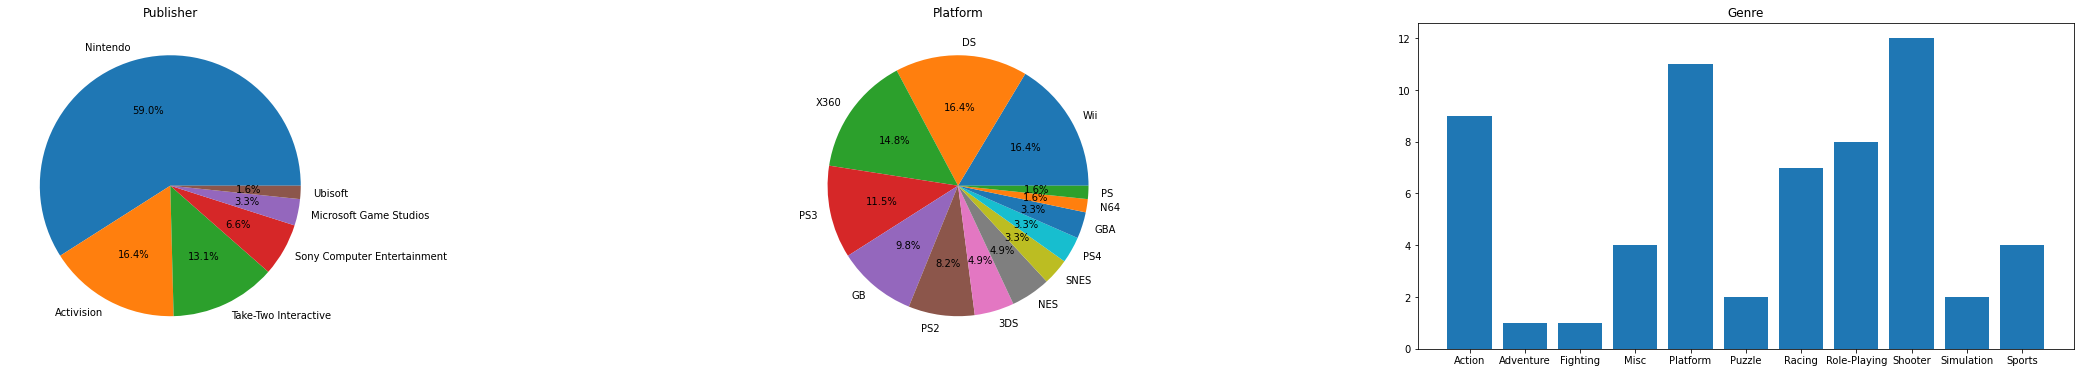

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(40, 6))
plt.subplot(131)
plt.pie(sorted_df['Publisher'].value_counts(), labels=sorted_df['Publisher'].value_counts().index, autopct='%.1f%%');
plt.title('Publisher');

plt.subplot(132)
plt.pie(sorted_df['Platform'].value_counts(), labels=sorted_df['Platform'].value_counts().index, autopct='%.1f%%');
plt.title('Platform');

plt.subplot(133)

#plt.bar(sorted_df['Genre'].value_counts(), labels=sorted_df['Platform'].value_counts().index, autopct='%.1f%%');
plt.title('Genre');
grouped_df3=sorted_df.groupby(['Genre']).count()
grouped_df3
plt.bar(grouped_df3.index, grouped_df3['Name']);

#결론. 다음 분기에 어떤 게임을 설계해야 할까

4-1. 장르는 트렌드와 시장규모 측면에서 유리한 것으로 선정

4-2. 퍼블리셔는 그 장르의 큰 규모 게임 사례가 있으면 좋겠다. (운영 노하우가 있을거라 가정)

4-3. 플랫폼은 퍼블리셔가 가장 많이 사용하는 플랫폼을 우
선으로 (+ 장르에 상관없이 큰 규모의 게임 사례가 있으면 좋겠다.)

#4-1. 장르의 트렌드
트렌드와 시장의 크기를 고려하여 Action 장르로 선정

y축은 출고량


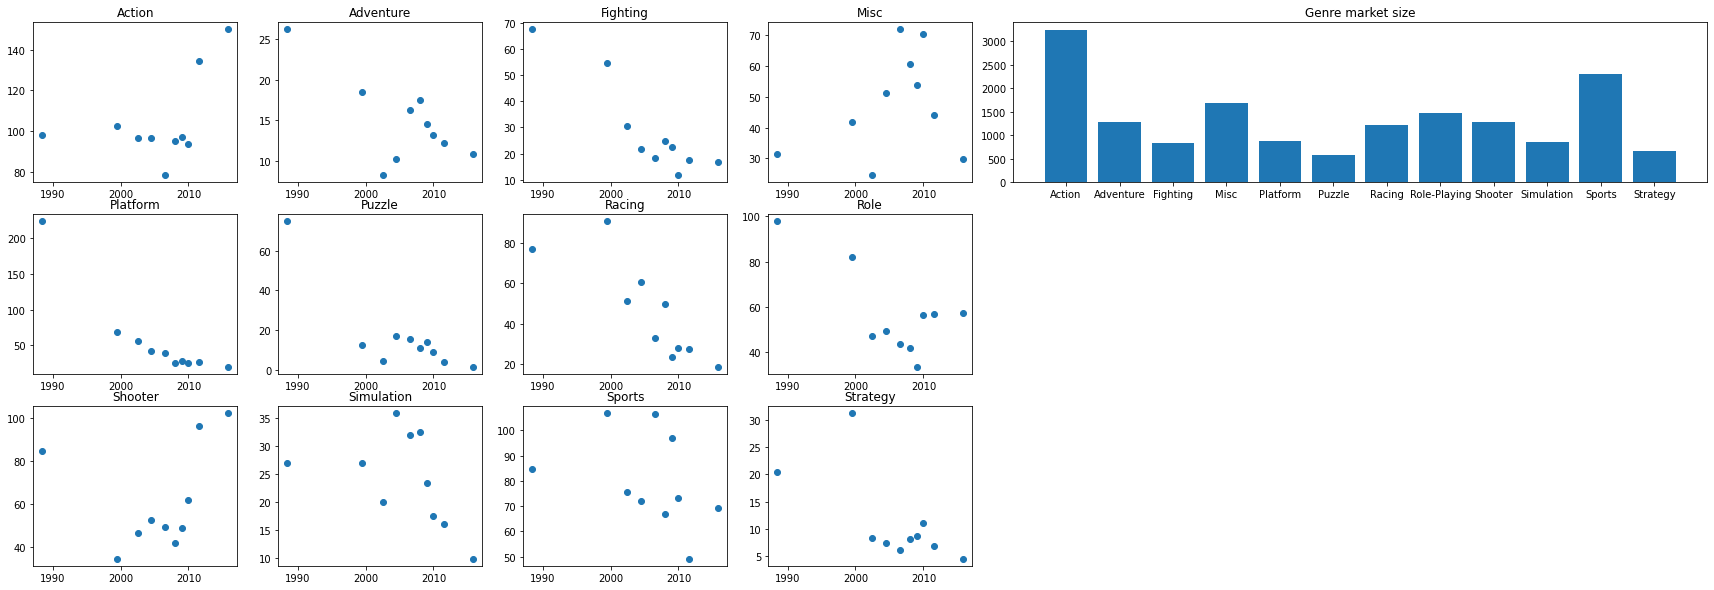

In [ ]:
print('y축은 출고량')
plt.figure(figsize=(30,10))
ax1 = plt.subplot2grid((3,7), (0,0))
plt.scatter(grouped_df2['Year'],grouped_df2['Action'])
plt.title('Action')
ax1 = plt.subplot2grid((3,7), (0,1))
plt.scatter(grouped_df2['Year'],grouped_df2['Adventure'])
plt.title('Adventure')
ax1 = plt.subplot2grid((3,7), (0,2))
plt.scatter(grouped_df2['Year'],grouped_df2['Fighting'])
plt.title('Fighting')
ax1 = plt.subplot2grid((3,7), (0,3))
plt.scatter(grouped_df2['Year'],grouped_df2['Misc'])
plt.title('Misc')
ax1 = plt.subplot2grid((3,7), (1,0))
plt.scatter(grouped_df2['Year'],grouped_df2['Platform'])
plt.title('Platform')
ax1 = plt.subplot2grid((3,7), (1,1))
plt.scatter(grouped_df2['Year'],grouped_df2['Puzzle'])
plt.title('Puzzle')
ax1 = plt.subplot2grid((3,7), (1,2))
plt.scatter(grouped_df2['Year'],grouped_df2['Racing'])
plt.title('Racing')
ax1 = plt.subplot2grid((3,7), (1,3))
plt.scatter(grouped_df2['Year'],grouped_df2['Role-Playing'])
plt.title('Role')
ax1 = plt.subplot2grid((3,7), (2,0))
plt.scatter(grouped_df2['Year'],grouped_df2['Shooter'])
plt.title('Shooter')
ax1 = plt.subplot2grid((3,7), (2,1))
plt.scatter(grouped_df2['Year'],grouped_df2['Simulation'])
plt.title('Simulation')
ax1 = plt.subplot2grid((3,7), (2,2))
plt.scatter(grouped_df2['Year'],grouped_df2['Sports'])
plt.title('Sports')
ax1 = plt.subplot2grid((3,7), (2,3))
plt.scatter(grouped_df2['Year'],grouped_df2['Strategy'])
plt.title('Strategy');

ax1 = plt.subplot2grid((3,7), (0,4), colspan=3)
plt.bar(grouped_df1.index, grouped_df1.sum(axis=1))
plt.title('Genre market size');

> ## **4-2. 퍼블리셔 별 Action 게임 데이터**

Publisher
Ubisoft                 22
Nintendo                21
Take-Two Interactive    20
Name: Name, dtype: int64
         Year  Game_sales
3483   2013.0       21390
14669  2004.0       20810
10913  2013.0       16380
5340   2002.0       16150
9786   2001.0       13100


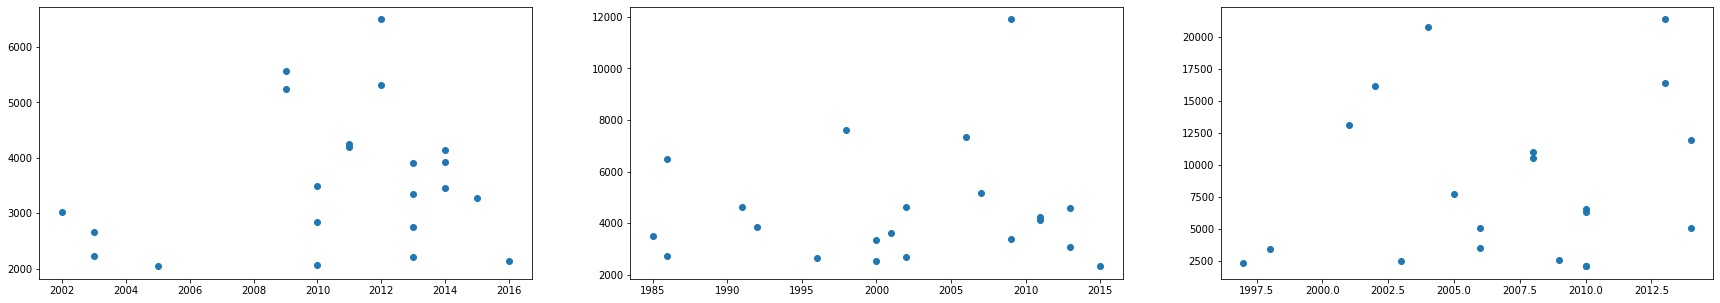

In [ ]:
action_df=df[df['Genre']=='Action'].sort_values(by=['Game_sales'], ascending=False)
i=0
while action_df['Game_sales'].iloc[i]>2000:
  i+=1
action_df=action_df.iloc[0:i]
print(action_df.groupby('Publisher').count()['Name'].sort_values(ascending=False)[0:3])

plt.figure(figsize=(30,5))
plt.subplot(131)
plt.scatter(action_df[action_df['Publisher'] == 'Ubisoft']['Year'], action_df[action_df['Publisher'] == 'Ubisoft']['Game_sales'])
plt.subplot(132)
plt.scatter(action_df[action_df['Publisher'] == 'Nintendo']['Year'], action_df[action_df['Publisher'] == 'Nintendo']['Game_sales'])
plt.subplot(133)
plt.scatter(action_df[action_df['Publisher'] == 'Take-Two Interactive']['Year'], action_df[action_df['Publisher'] == 'Take-Two Interactive']['Game_sales'])

print(action_df[action_df['Publisher'] == 'Take-Two Interactive'][['Year','Game_sales']][0:5])

## **4-3. 플랫폼 : 퍼블리셔와 밀접한 플랫폼**

In [ ]:
print(pd.DataFrame(df[df['Publisher']=='Take-Two Interactive'].groupby(['Platform']).count()).sort_values(by='Name', ascending=False)['Name'][0:3])

print(df[df['Publisher']=='Take-Two Interactive'][df['Platform']=='PS3'].sort_values(by='Year').iloc[-1]['Year'])

Platform
X360    70
PS2     60
PS3     53
Name: Name, dtype: int64
2016.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


#결론 : Action 게임을,Take-Two Interactive 퍼블리셔와 함께, X360 혹은 PS3 플랫폼에서 설계할것이다.